In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
species = {'alpha1': [32, 42],
           'alpha2': [3, 10, 28, 29],
           'alpha3': [61],
           'alpha4': [2, 27, 57],
           'alpha5': [51, 69],
           'alpha6': [56],
           'alpha7': [18, 39, 45, 59, 68, 70],
           'alpha8': [7],
           'alpha9': [16, 31, 33, 35, 52, 58, 67],
           'alpha11': [34],
           'alpha13': [54],
           'beta1': [5, 8, 12, 14, 19, 20, 21, 24, 25, 36, 47, 93], 
           'beta2': [9, 15, 17, 22, 23, 37, 38, 80, 100, 151],
           'beta3': [49, 75, 76], 
           'beta4': [92],
           'beta5': [96],
           'gamma1': [4, 65, 95], 
           'gamma2': [48],
           'gamma3': [50],
           'gamma4': [60],
           'gamma5': [88],
           'gamma12': [132],
           'gamma24': [197],
           'mu': [1],
           'nu': [41],
}

inverted_dict = {}
for specy, types in species.items():
    for typ in types:
        inverted_dict[typ] = specy
        
inverted_dict = {'HPV' + str(i): inverted_dict[i] for i in sorted(inverted_dict.keys())}

types_interested = [i for i in inverted_dict.keys()]

In [3]:
import matplotlib.path as mpath
import matplotlib.patches as mpatches


def add_label_band(ax, top, bottom, label, *,
                   spine_pos=-0.05, tip_pos=-0.02,
                   rotation=0):
    """
    Helper function to add bracket around y-tick labels.

    Parameters
    ----------
    ax : matplotlib.Axes
        The axes to add the bracket to

    top, bottom : floats
        The positions in *data* space to bracket on the y-axis

    label : str
        The label to add to the bracket

    spine_pos, tip_pos : float, optional
        The position in *axes fraction* of the spine and tips of the bracket.
        These will typically be negative

    Returns
    -------
    bracket : matplotlib.patches.PathPatch
        The "bracket" Aritst.  Modify this Artist to change the color etc of
        the bracket from the defaults.

    txt : matplotlib.text.Text
        The label Artist.  Modify this to change the color etc of the label
        from the defaults.

    """
    # grab the yaxis blended transform
    transform = ax.get_yaxis_transform()

    # add the bracket
    bracket = mpatches.PathPatch(
        mpath.Path(
            [
                [tip_pos, top],
                [spine_pos, top],
                [spine_pos, bottom],
                [tip_pos, bottom],
            ]
        ),
        transform=transform,
        clip_on=False,
        facecolor="none",
        edgecolor="k",
        linewidth=1,
    )
    ax.add_artist(bracket)

    # add the label
    txt = ax.text(
        spine_pos,
        (top + bottom) / 2,
        label,
        ha="right",
        va="center",
        rotation=rotation,
        clip_on=False,
        transform=transform,
    )

    return bracket, txt

In [4]:
def split_string(s):
    return (''.join(c for c in s if c.isdigit()) or None, 
        ''.join(c for c in s if c.isalpha()) or None)

In [5]:
threshold = 0.8
proteins = ['E1', 'E2', 'E6', 'E7']
colormap = 'Blues'

In [6]:
viruses = pd.read_csv('../results/figure_1_viruses.csv')['0'].values
with open('../results/figure_1.pkl', 'rb') as file:
    results = pkl.load(file)
np.fill_diagonal(results[0], 0)
np.fill_diagonal(results[1], 0)
np.fill_diagonal(results[2], 0)
np.fill_diagonal(results[3], 0)

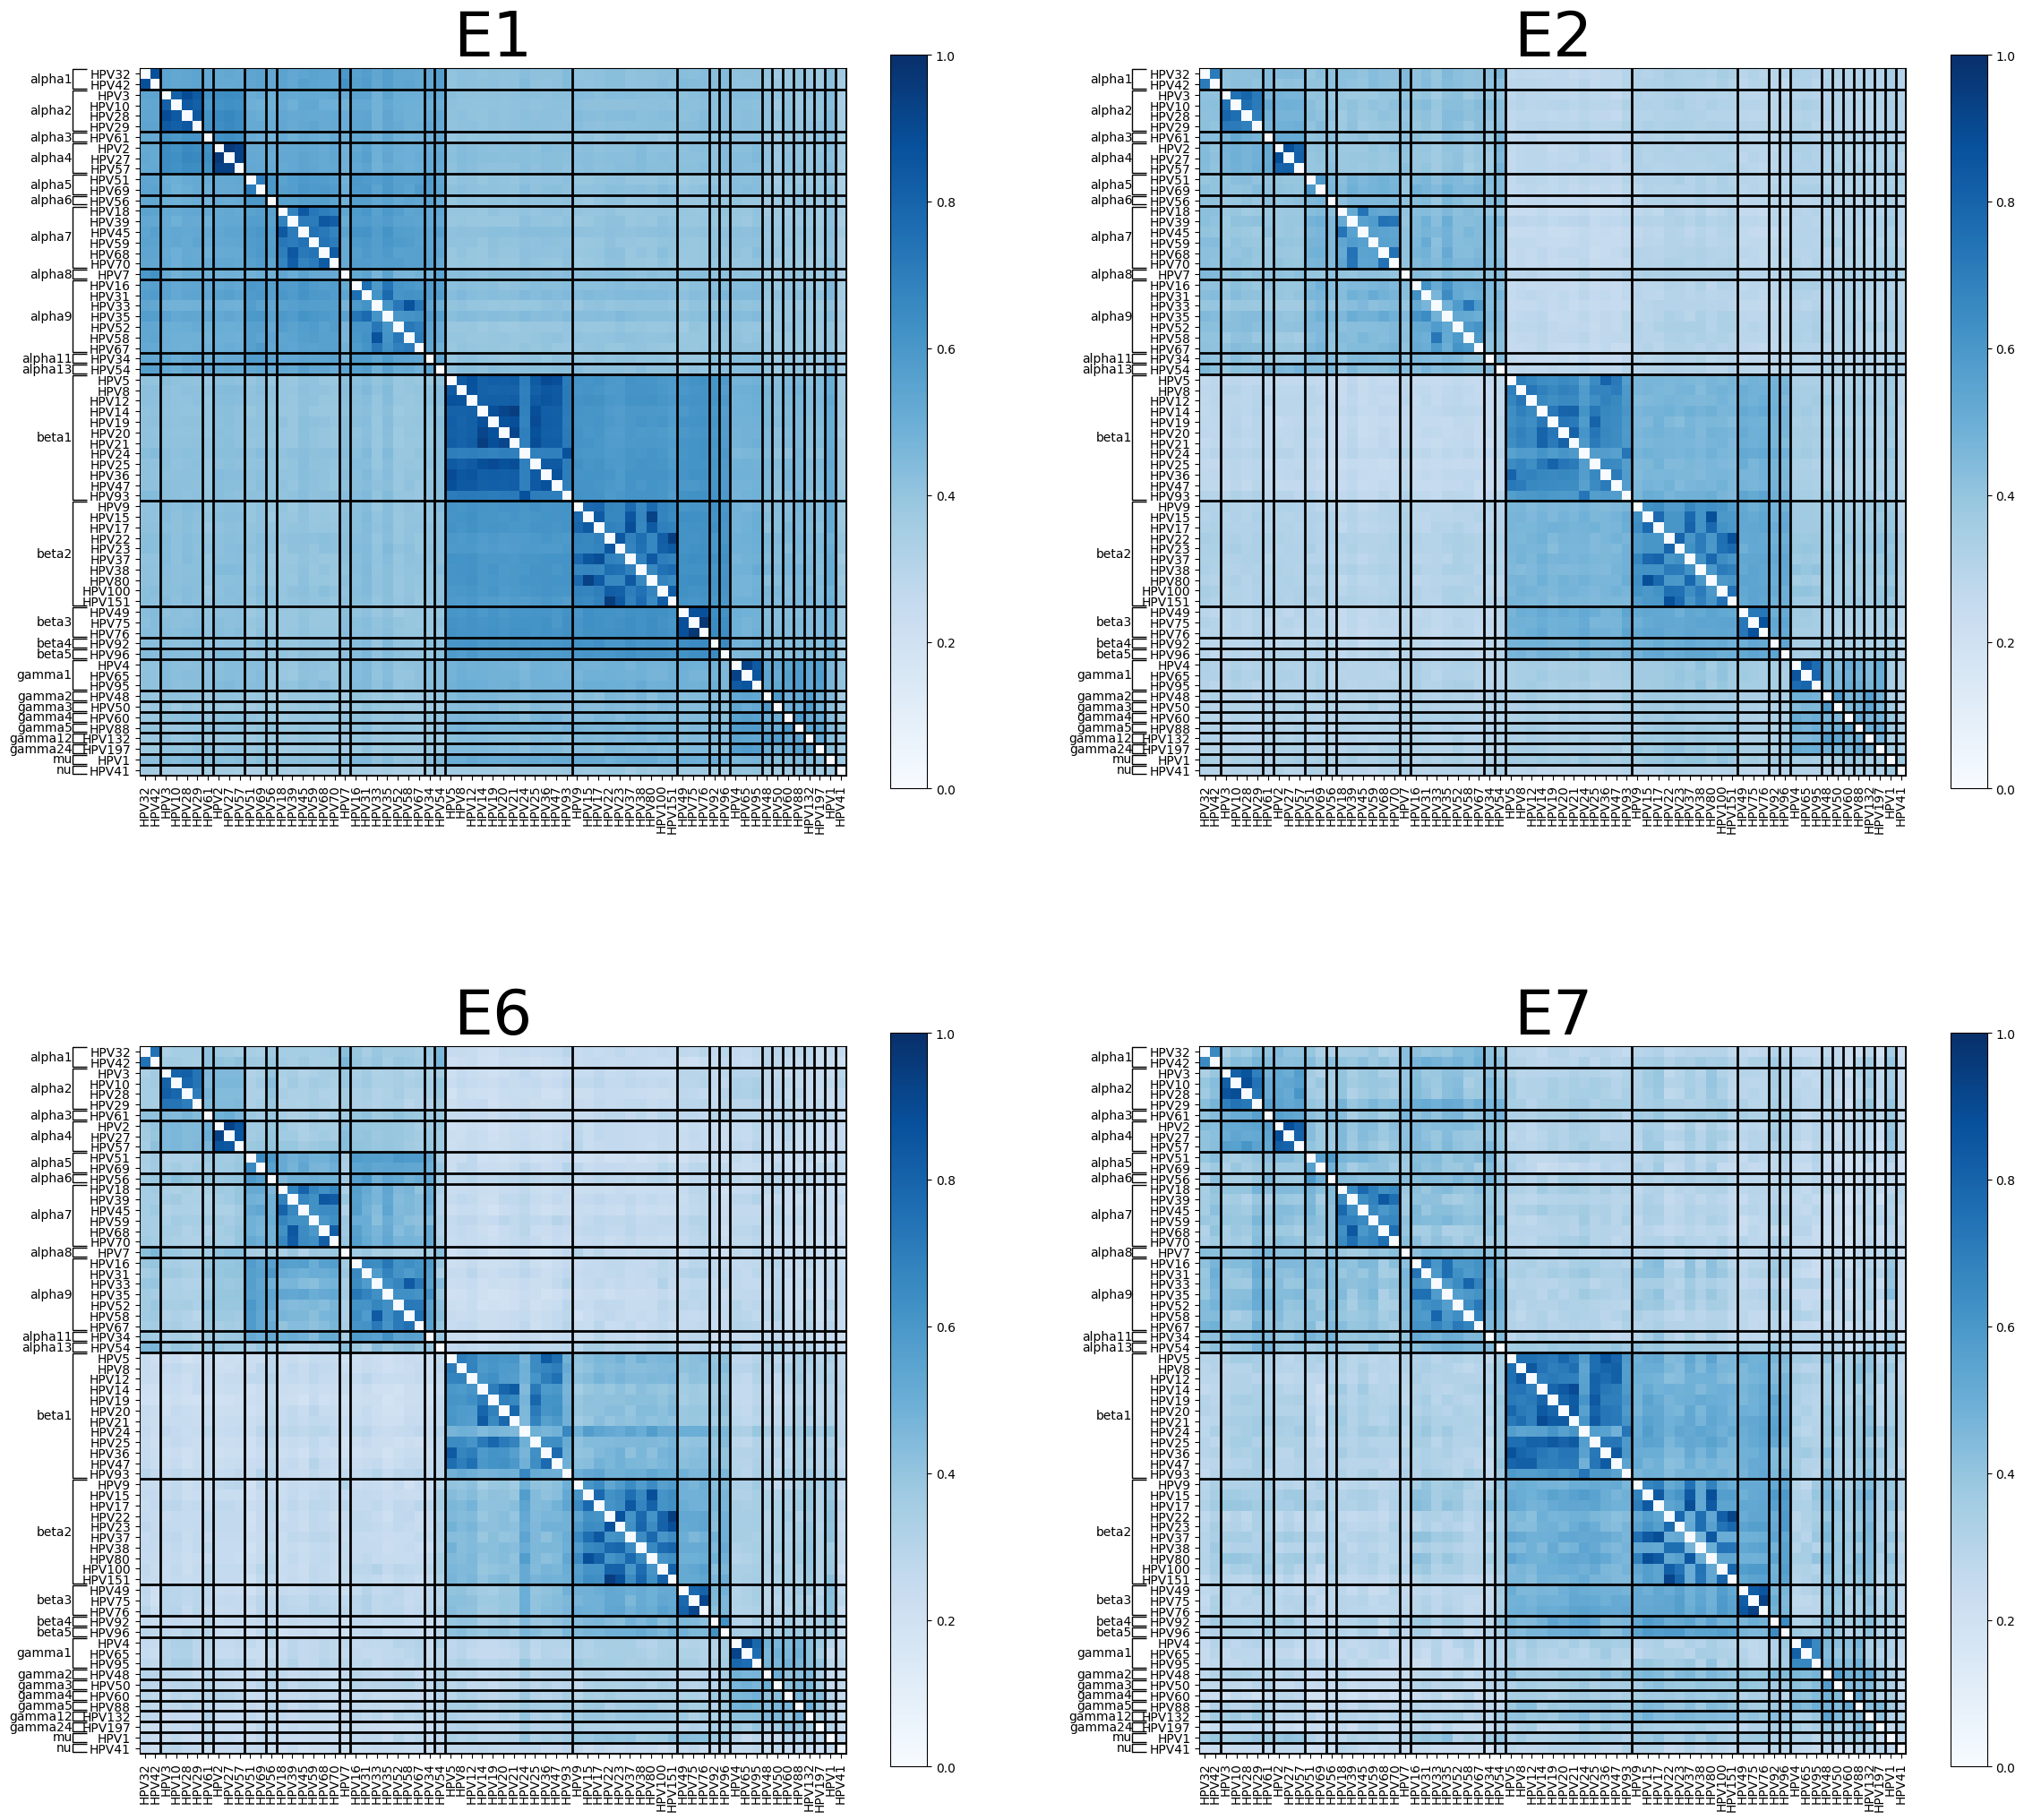

In [7]:
i = 0
fig, axes = plt.subplots(2, 2, figsize=(28, 26), facecolor='white')
for axis in axes:
    for ax in axis:
        temp_results = pd.DataFrame(results[i], columns=viruses).set_index(viruses)
        temp_results = temp_results[types_interested][temp_results.index.isin(types_interested)]
        temp_results['species'] = temp_results.index.map(inverted_dict)
        #  = temp_results.species.apply(split_string)
        temp_results[['num_species', 'let_species']] = np.concatenate(
        [[i[0], i[1]] for i in temp_results.species.apply(split_string)]).reshape(-1, 2)
        temp_results['num_species'] = temp_results['num_species'].fillna(0)
        temp_results['num_species'] = temp_results['num_species'].astype(int)
        temp_results['num_type'] = temp_results.index.to_series().apply(lambda x: int(x[3:]))
        temp_results = temp_results.sort_values(['let_species', 'num_species', 'num_type'])
        temp_results = temp_results[list(temp_results.index)]
        im = ax.imshow(temp_results.values, 
                       cmap=colormap,
                       vmin=0,
                       vmax=1,
                       )
        cbar = fig.colorbar(im, ax=ax, shrink=0.90) # asdfasdf
        ax.set_xticks(np.arange(len(temp_results)))
        ax.set_xticklabels(list(temp_results.index))
        ax.set_yticks(np.arange(len(temp_results)))
        ax.set_yticklabels(list(temp_results.index))
        ax.tick_params(rotation=90, axis='x')
        ax.set_title(proteins[i],
                     fontdict={'fontsize': 50})

        offset = -0.5
        for specy in species.keys():
            add_label_band(ax,
                           offset+0.09, offset + len(species[specy])-0.09,
                           specy,
                           spine_pos=-0.095,
                           tip_pos=-0.075)
            offset = len(species[specy]) + offset
            ax.plot([offset, offset],
                    [-0.5, len(temp_results) - 0.5],
                    linewidth = 3.5 if i in [9, 14] else 2,
                    color ='k')
            ax.plot([-0.5, len(temp_results) - 0.5],
                    [offset, offset],
                    linewidth = 3.5 if i in [9, 14] else 2,
                    color='k')
        
        in_species_homologies = temp_results.copy()
        out_species_homologies = temp_results.copy()

        for specy, types in species.items():
            sub_search = ["HPV" + str(i) for i in types]
            other_cols = [i for i in temp_results.columns if i not in sub_search]
            for index, row in temp_results.iterrows():
                if index not in sub_search:
                    pass
                else:
                    out_species_homologies.loc[index, sub_search] = np.inf
                    in_species_homologies.loc[index, other_cols] = np.inf

        in_species_homologies.to_csv("../results/in_species_homologies_{}.csv".format(proteins[i]))
        out_species_homologies.to_csv("../results/out_species_homologies_{}.csv".format(proteins[i]))
        
        i = i + 1

    # fig.suptitle('Heatmap of Percent Homology of HPV viruses', fontsize=40)
    plt.savefig('../figures/figure_1_' + colormap + '.png', bbox_inches='tight', dpi=1200)

protein: E1
In-species statistics
Median: 0.7718, Mean: 0.7677, Min: 0.5838, Max: 0.9688, StD: 0.0928
Out-species statistics
Median: 0.4277, Mean: 0.4611, Min: 0.3267, Max: 0.6637, StD: 0.077
Statistical Significance
TtestResult(statistic=48.22749075610992, pvalue=0.0, df=2209.0)
RanksumsResult(statistic=21.15305741760561, pvalue=2.5862444845996185e-99)


protein: E2
In-species statistics
Median: 0.6393, Mean: 0.6509, Min: 0.4665, Max: 0.8824, StD: 0.0908
Out-species statistics
Median: 0.3228, Mean: 0.3495, Min: 0.232, Max: 0.5875, StD: 0.0749
Statistical Significance
TtestResult(statistic=48.74494493870842, pvalue=0.0, df=2209.0)
RanksumsResult(statistic=21.198439605802108, pvalue=9.87154561566695e-100)


protein: E6
In-species statistics
Median: 0.6454, Mean: 0.6642, Min: 0.4425, Max: 0.9433, StD: 0.1115
Out-species statistics
Median: 0.2833, Mean: 0.3152, Min: 0.1834, Max: 0.6267, StD: 0.0869
Statistical Significance
TtestResult(statistic=48.30248210349772, pvalue=0.0, df=2209.0)
Ra

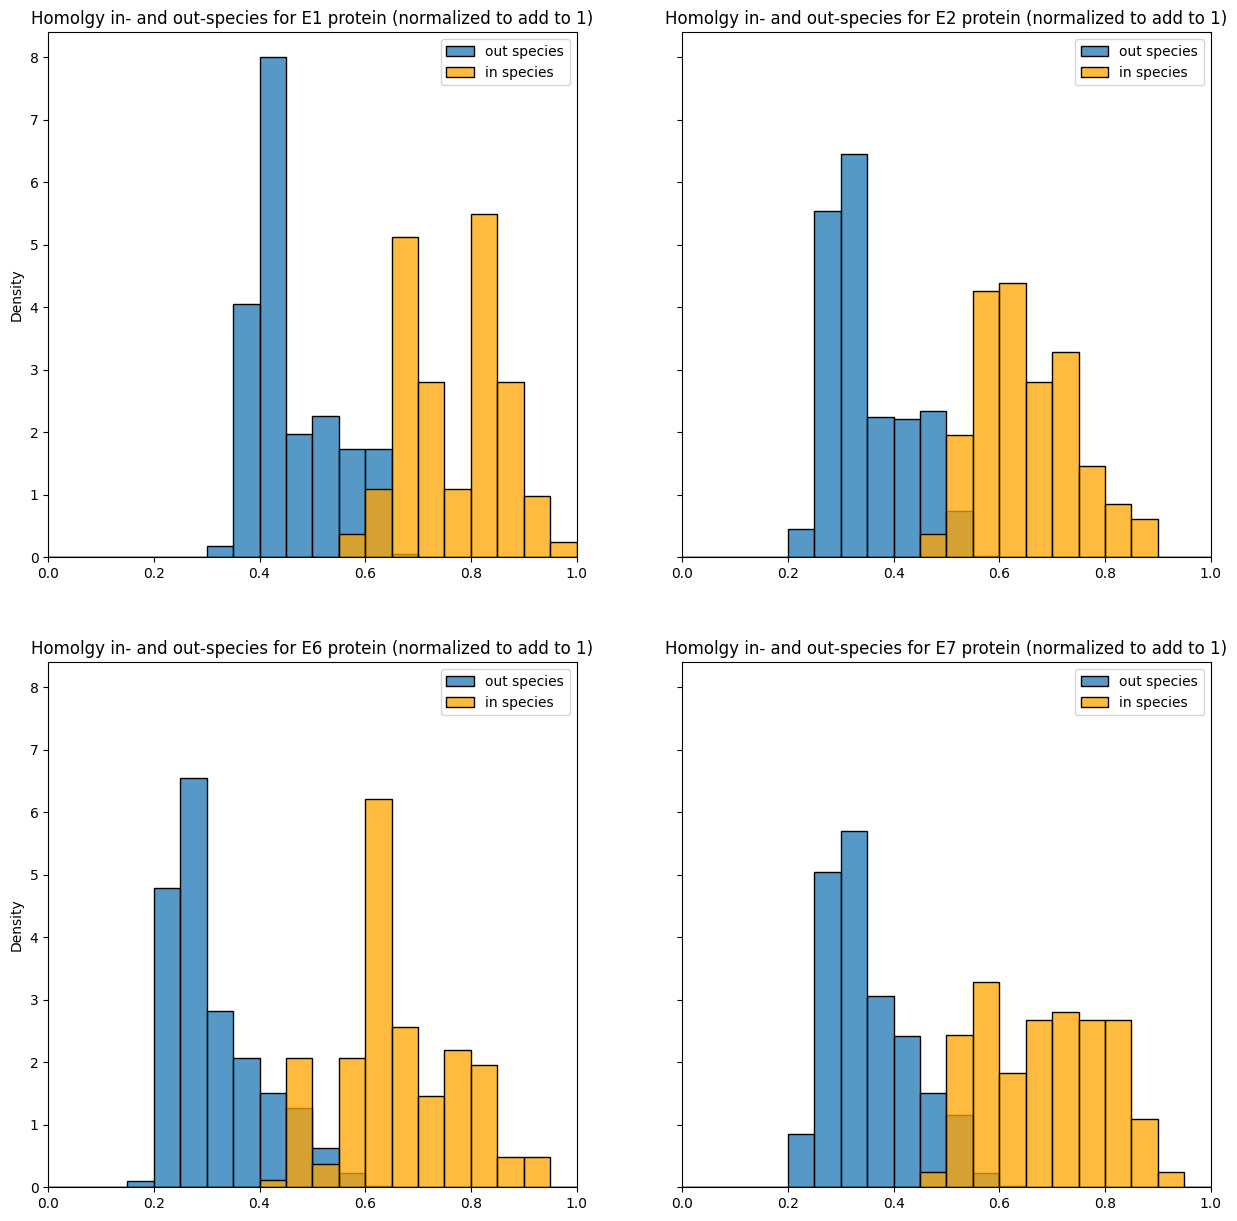

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15), sharey=True)

axes = np.array(axes).flatten()

for i, protein in enumerate(["E1", "E2", "E6", "E7"]):
    print("protein: {}".format(protein))
    in_species_homologies = pd.read_csv("../results/in_species_homologies_{}.csv".format(protein),
                                        index_col=0)
    out_species_homologies = pd.read_csv("../results/out_species_homologies_{}.csv".format(protein),
                                         index_col=0)
    # display(in_species_homologies.iloc[:6, :6])
    in_values = in_species_homologies.values.copy()
    in_values[np.tril_indices(in_values.shape[0])] = np.inf
    in_group_values = in_values.flatten()[np.isfinite(in_values.flatten())]
    # display(out_species_homologies.iloc[:6, :6])
    out_values = out_species_homologies.values.copy()
    out_values[np.tril_indices(out_values.shape[0])] = np.inf
    out_group_values = out_values.flatten()[np.isfinite(out_values.flatten())]
    
    print("In-species statistics")
    print("Median: {}, Mean: {}, Min: {}, Max: {}, StD: {}".format(
            np.round(np.median(in_group_values), 4),
            np.round(in_group_values.mean(), 4),
            np.round(in_group_values.min(), 4),
            np.round(in_group_values.max(), 4),
            np.round(in_group_values.std(), 4)))
    print("Out-species statistics")
    print("Median: {}, Mean: {}, Min: {}, Max: {}, StD: {}".format(
            np.round(np.median(out_group_values), 4),
            np.round(out_group_values.mean(), 4),
            np.round(out_group_values.min(), 4),
            np.round(out_group_values.max(), 4),
            np.round(out_group_values.std(), 4)))
    print("Statistical Significance")
    print(stats.ttest_ind(in_group_values, out_group_values))
    print(stats.ranksums(in_group_values, out_group_values))
    print()
    print()
    
    sns.histplot(out_group_values,
                 label="out species", 
                 bins=np.linspace(0, 1, 21),
                 #color='blue',
                 stat='density',
                 ax=axes[i])
    sns.histplot(in_group_values,
                 label="in species",
                 bins=np.linspace(0, 1, 21),
                 color='orange',
                 stat='density',
                 ax=axes[i])
    axes[i].legend()
    axes[i].set_xlim(0, 1)
    axes[i].set_title(f"Homolgy in- and out-species for {protein} protein (normalized to add to 1)");